In [1]:
import pandas as pd
ratings_df = pd.read_csv("Dataset\last\XWines_Slim_150K_ratings.csv") 
wines_df = pd.read_csv("Dataset\last\XWines_Slim_1K_wines.csv", index_col="WineID")
wines_df['WineID'] = wines_df.index

body_mapping = {
    'Very light-bodied': 1,
    'Light-bodied': 2,
    'Medium-bodied': 3,
    'Full-bodied': 4,
    'Very full-bodied': 5
}
acidity_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}

type_mapping = {
    'White': 1,
    'Rosé': 2,
    'Red': 3,
    'Sparkling': 4,
    'Dessert': 5,
    'Dessert/Port': 6
}



# Apply the mappings to the DataFrame
wines_df['Body'] = wines_df['Body'].map(body_mapping)
wines_df['Acidity'] = wines_df['Acidity'].map(acidity_mapping)
wines_df['Type'] = wines_df['Type'].map(type_mapping)
display(wines_df.head(3))


C:\Users\sofia\AppData\Local\Temp\ipykernel_6848\1503363948.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv("Dataset\last\XWines_Slim_150K_ratings.csv")


,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages,WineID
WineID,,,,,,,,,,,,,,,,,
100001,Espumante Moscatel,4,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,3,3,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201...",100001
100002,Ancellotta,3,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,3,2,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200...",100002
100003,Cabernet Sauvignon,3,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,4,3,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",100003


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
import numpy as np


wine_features = wines_df[['Type', 'Grapes', 'Harmonize', 'ABV', 'Body', 'Acidity', 'Vintages']]

tfidf = TfidfVectorizer(stop_words='english')
wine_tfidf = tfidf.fit_transform(wine_features['Harmonize'].fillna(''))

# Label Encoding 
label_encoder = LabelEncoder()

type_encoded = label_encoder.fit_transform(wine_features['Type'])
body_encoded = label_encoder.fit_transform(wine_features['Body'])
acidity_encoded = label_encoder.fit_transform(wine_features['Acidity'])
abv_encoded = label_encoder.fit_transform(wine_features['ABV'])


wine_label_encoding = np.column_stack([type_encoded, body_encoded, acidity_encoded, abv_encoded])


wine_features_combined = sp.hstack([wine_tfidf, wine_label_encoding])


cosine_sim = cosine_similarity(wine_features_combined, wine_features_combined)


In [10]:

wines_df = wines_df.reset_index(drop=True)

def get_similarities(wine_id, cosine_sim=cosine_sim):
    if wine_id not in wines_df['WineID'].values:
        return f"Wine with ID '{wine_id}' not found. Please check the WineID."

    idx = wines_df[wines_df['WineID'] == wine_id].index[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]*5))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:1001] 
    wine_indices = [i[0] for i in sim_scores]
    wine_similarities = [i[1] for i in sim_scores]
    
    similarities = wines_df.iloc[wine_indices][['WineName', 'WineID', 'Type', 'Grapes', 'Body', 'Acidity', 'ABV', 'Harmonize']].copy()
    
    similarities['Similarity'] = wine_similarities
    
    return similarities


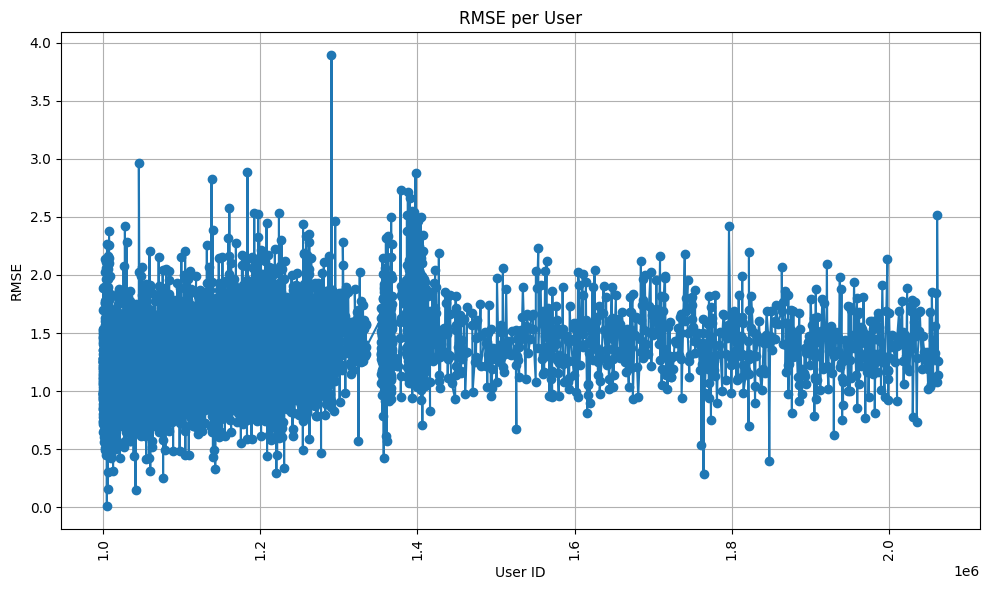

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


users_ratings = ratings_df.groupby('UserID').count()

selected = users_ratings['Rating'] > 10
selected_users = users_ratings.loc[selected].index

rmse_list = []
user_ids = []


for user_id in selected_users:
    user_ratings = ratings_df[ratings_df['UserID'] == user_id].sort_values(by='Rating', ascending=False)
    top_rated_wine = user_ratings.iloc[0]  
    top_wine_id = top_rated_wine['WineID']
    
    similarities = get_similarities(top_wine_id)
    
    rated_wines = user_ratings['WineID'].values[1:] 
    actual_ratings = user_ratings['Rating'].values[1:] 
    
    predicted_ratings = []
    
    for wine_id in rated_wines:
        sim_wine = similarities[similarities['WineID'] == wine_id]
        
        if not sim_wine.empty:
            predicted_rating = sim_wine['Similarity'].values[0]
            predicted_ratings.append(predicted_rating)
        else:
            predicted_ratings.append(np.nan)
    
    predicted_ratings_clean = [r for r in predicted_ratings if not np.isnan(r)]
    actual_ratings_clean = actual_ratings[:len(predicted_ratings_clean)] 
    
    if len(predicted_ratings_clean) > 0 and len(actual_ratings_clean) > 0:
       
        rmse = np.sqrt(mean_squared_error(actual_ratings_clean, predicted_ratings_clean))
        rmse_list.append(rmse)
        user_ids.append(user_id)


rmse_df = pd.DataFrame({
    'user': user_ids,
    'rmse': rmse_list
})

plt.figure(figsize=(10, 6))
plt.plot(rmse_df['user'], rmse_df['rmse'], label='User RMSE', marker='o')
plt.xlabel('User ID')
plt.ylabel('RMSE')
plt.title('RMSE per User')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


Standard Deviation RMSE: 0.21458442334631875


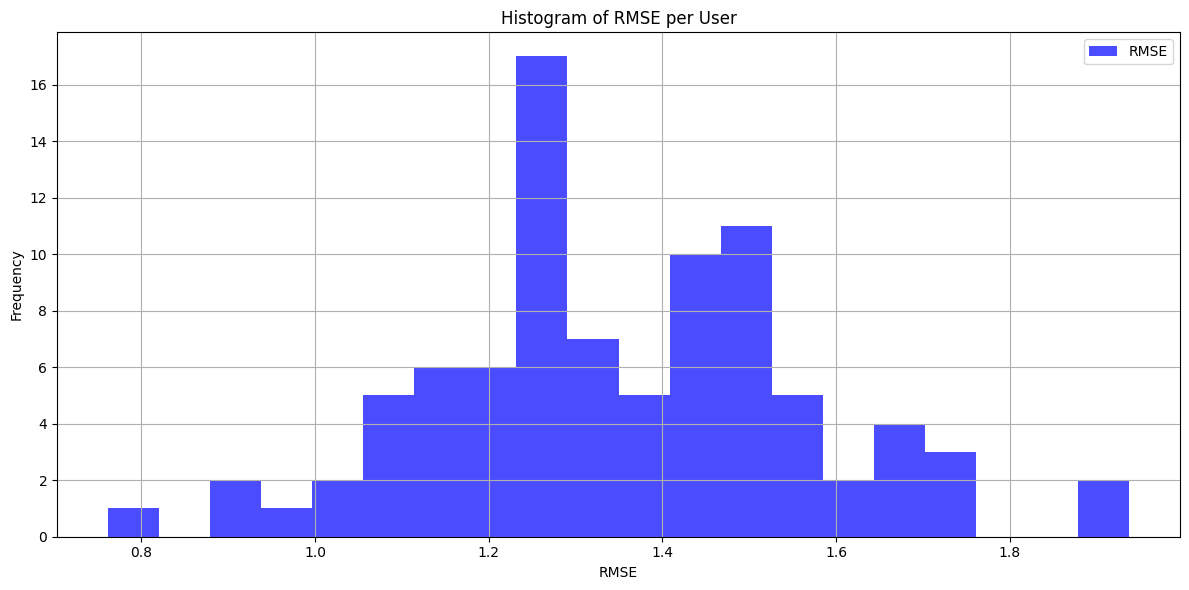

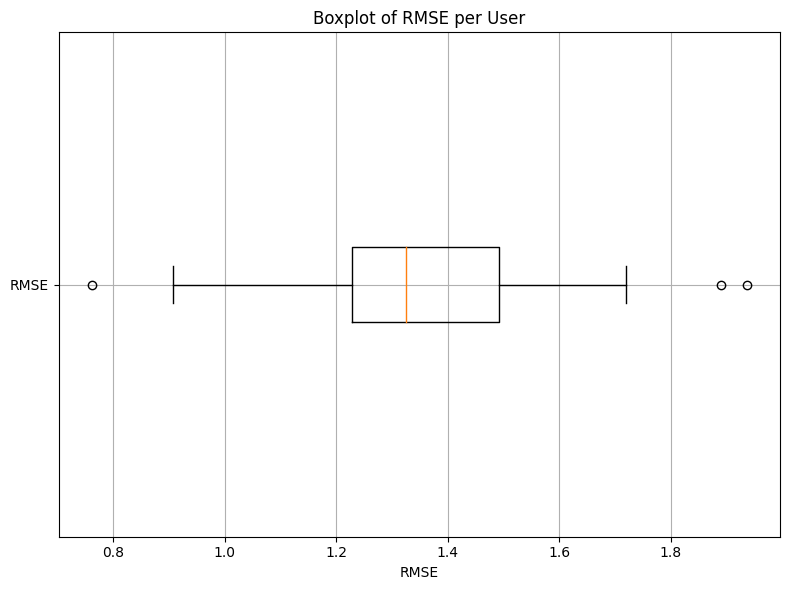

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


users_ratings = ratings_df.groupby('UserID').count()

selected = users_ratings['Rating'] > 40
selected_users = users_ratings.loc[selected].index

rmse_list = []
user_ids = []

for user_id in selected_users:
    user_ratings = ratings_df[ratings_df['UserID'] == user_id].sort_values(by='Rating', ascending=False)
    
    top_rated_wine = user_ratings.iloc[0] 
    top_wine_id = top_rated_wine['WineID']
    
    similarities = get_similarities(top_wine_id)
    
    rated_wines = user_ratings['WineID'].values[1:] 
    actual_ratings = user_ratings['Rating'].values[1:]
    
    predicted_ratings = []
    
    for wine_id in rated_wines:
        sim_wine = similarities[similarities['WineID'] == wine_id]
        
        if not sim_wine.empty:
            predicted_rating = sim_wine['Similarity'].values[0]
            predicted_ratings.append(predicted_rating)
        else:
            predicted_ratings.append(np.nan)
    
    predicted_ratings_clean = [r for r in predicted_ratings if not np.isnan(r)]
    actual_ratings_clean = actual_ratings[:len(predicted_ratings_clean)] 
    
    if len(predicted_ratings_clean) > 0 and len(actual_ratings_clean) > 0:
        rmse = np.sqrt(mean_squared_error(actual_ratings_clean, predicted_ratings_clean))
        rmse_list.append(rmse)
        user_ids.append(user_id)

rmse_df = pd.DataFrame({
    'user': user_ids,
    'rmse': rmse_list
})


rmse_df_cleaned = rmse_df.dropna(subset=['rmse'])


std_rmse = rmse_df_cleaned['rmse'].std()
print(f"Standard Deviation RMSE: {std_rmse}")


plt.figure(figsize=(12, 6))
plt.hist(rmse_df_cleaned['rmse'], bins=20, alpha=0.7, color='blue', label='RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE per User')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(rmse_df_cleaned['rmse'], labels=['RMSE'], vert=False)
plt.xlabel('RMSE')
plt.title('Boxplot of RMSE per User')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
users_with_recommended_liked_wine = 0


high_rating_threshold = 4.9
high_similarity_threshold = 4.9


for user_id in selected_users:
    user_ratings = ratings_df[ratings_df['UserID'] == user_id].sort_values(by='Rating', ascending=False)
    
    top_rated_wine = user_ratings.iloc[0] 
    top_wine_id = top_rated_wine['WineID']
    
    similarities = get_similarities(top_wine_id)

    recommended_wines = similarities[similarities['Similarity'] > high_similarity_threshold]

    rated_wines = user_ratings[['WineID', 'Rating']].copy()


    merged = pd.merge(rated_wines, recommended_wines, on='WineID', how='inner')
    
    liked_recommended_wines = merged[merged['Rating'] >= high_rating_threshold]
    
    if not liked_recommended_wines.empty:
        users_with_recommended_liked_wine += 1 

user_coverage = (users_with_recommended_liked_wine / len(selected_users)) * 100

print(f"User Coverage: {user_coverage:.2f}% ")


User Coverage: 73.03% 
